## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

from jax import random
from jax import vmap
from flax import serialization
from flax import linen as nn
from functools import partial
from tqdm import tqdm

## The Task: Quadratic Functions

In [2]:
def quadratic_data(rng, batch_size=128, dim=10):
    keys = jax.random.split(rng, 3)
    w = jax.random.normal(keys[0], (batch_size, dim, dim))
    y = jax.random.normal(keys[1], (batch_size, dim))
    theta = jax.random.normal(keys[2], (batch_size, dim))
    return w, y, theta


def quadratic_task(w, y, theta, opt_fn, opt_state, steps=100):
    @jax.jit
    def f(theta):
        product = vmap(jnp.matmul)(w, theta)
        return jnp.mean(jnp.sum((product - y) ** 2, axis=1))

    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(f)(theta)
        updates, opt_state = opt_fn(grads, opt_state)
        theta += updates
        losses.append(loss)

    return jnp.stack(losses), theta, opt_state

In [3]:
class LSTMOptimizer(nn.Module):
    hidden_units: int = 20

    def setup(self):
        self.lstm1 = nn.recurrent.LSTMCell()
        self.lstm2 = nn.recurrent.LSTMCell()
        self.fc = nn.Dense(1)

    def __call__(self, gradient, state):
        # gradients of optimizee do not depend on optimizer
        gradient = jax.lax.stop_gradient(gradient)

        # expand parameter dimension to extra batch dimension so that network
        # is "coodinatewise"
        gradient = gradient[..., None]

        carry1, carry2 = state
        carry1, x = self.lstm1(carry1, gradient)
        carry2, x = self.lstm2(carry2, x)
        update = self.fc(x)
        update = update[..., 0]  # remove last dimension
        return update, (carry1, carry2)

    def initialize_carry(self, rng, params):
        return (
            nn.LSTMCell.initialize_carry(rng, params.shape, self.hidden_units),
            nn.LSTMCell.initialize_carry(rng, params.shape, self.hidden_units),
        )

In [4]:
def train(data_fn, task_fn, args):

    rng = jax.random.PRNGKey(seed=args["seed"])

    example_input = jnp.zeros((args["batch_size"], args["dim"]))
    lstm_opt = LSTMOptimizer()
    lstm_state = lstm_opt.initialize_carry(rng, example_input)
    params = lstm_opt.init(rng, example_input, lstm_state)

    meta_opt = optax.adam(learning_rate=args["learning_rate"])
    meta_opt_state = meta_opt.init(params)

    @jax.jit
    def train_step(params, w, y, theta, state):
        def loss_fn(params):
            update = partial(lstm_opt.apply, params)
            losses, _theta, _state = task_fn(
                w, y, theta, update, state, args["unroll_steps"]
            )
            return losses.sum(), (_theta, _state)

        (loss, (_theta, _state)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        return loss, grads, _theta, _state

    best_loss = jnp.inf

    tqdm_range = tqdm(range(args["steps"]))
    for _ in tqdm_range:
        rng, subkey = jax.random.split(rng)
        w, y, theta = data_fn(subkey, args["batch_size"], args["dim"])
        lstm_state = lstm_opt.initialize_carry(rng, theta)
        meta_loss = 0.0

        for _ in range(args["unrolls"]):
            loss, grads, theta, lstm_state = train_step(params, w, y, theta, lstm_state)
            updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
            params = optax.apply_updates(params, updates)
            meta_loss += loss

        if meta_loss < best_loss:
            best_loss = meta_loss
            with open(args["model_path"], "wb") as f:
                f.write(serialization.to_bytes(params))

        tqdm_range.set_postfix({"loss": meta_loss})

args = {
    "seed": 0, 
    "batch_size": 128,
    "dim": 10,
    "unroll_steps": 20,
    "unrolls": 5,
    "learning_rate": 1e-2,
    "steps": 1000,
    "model_path": "params.mp"
}

train(quadratic_data, quadratic_task, args)

100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s, loss=223.00006]


## Results

In [5]:
HAND_OPTIMIZERS = {
    "sgd": optax.sgd,
    "adam": optax.adam,
    "rmsprop": partial(optax.rmsprop),
    "nag": partial(optax.sgd, momentum=0.9, nesterov=True),
}

sgd, best lr: 1e-02
sgd, best lr: 3e-02
sgd, best lr: 1e-01
sgd, best lr: 3e-01
sgd, best lr: 1e+00
adam, best lr: 1e-02
adam, best lr: 3e-02
adam, best lr: 1e-01
adam, best lr: 3e-01
adam, best lr: 1e+00
rmsprop, best lr: 1e-02
rmsprop, best lr: 3e-02
nag, best lr: 1e-02
nag, best lr: 3e-02
nag, best lr: 1e-01
nag, best lr: 3e-01
nag, best lr: 1e+00


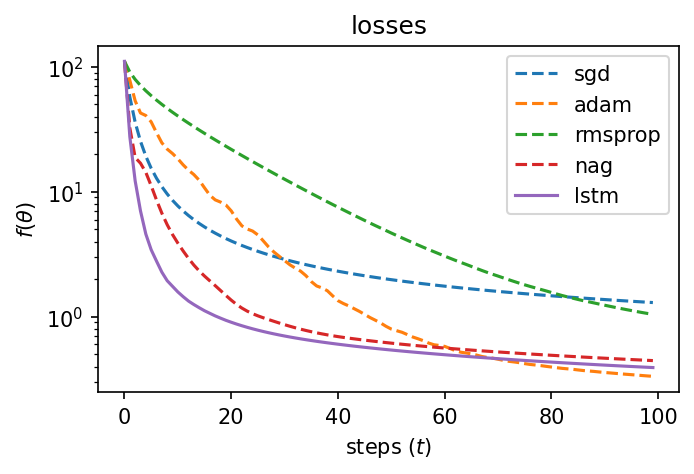

In [7]:
def eval_(data_fn, task_fn, args):
    
    rng = jax.random.PRNGKey(args["seed"])
    w, y, theta = data_fn(rng, args["batch_size"], args["dim"])

    plt.figure(dpi=150, figsize=(5, 3))

    for name, optimizer in HAND_OPTIMIZERS.items():
        best_losses = None
        for learning_rate in jnp.logspace(-2, 1, num=7):
            opt = optimizer(learning_rate=learning_rate)
            opt_state = opt.init(theta)
            losses, *_ = task_fn(w, y, theta, opt_state=opt_state, opt_fn=opt.update)

            if best_losses is None or losses[-1] < best_losses[-1]:
                best_losses = losses
                # print(f"{name}, best lr: {learning_rate:.0e}")

        plt.plot(best_losses, label=name, linestyle="--")

    lstm_opt = LSTMOptimizer()
    lstm_state = lstm_opt.initialize_carry(rng, theta)
    params = lstm_opt.init(rng, theta, lstm_state)

    with open(args["model_path"], "rb") as f:
        params = serialization.from_bytes(params, f.read())

    update = partial(lstm_opt.apply, params)
    losses, *_ = task_fn(w, y, theta, opt_state=lstm_state, opt_fn=update)
    plt.plot(losses, label="lstm")

    plt.legend()
    plt.title("losses")
    plt.xlabel("steps ($t$)")
    plt.ylabel("$f(\\theta)$")
    plt.yscale("log")

eval(quadratic_task, args)

## MNIST

In [ ]:
def mnist_data():
  ...

def mnist_task():
  ...

In [ ]:
args = {
    "seed": 0, 
    "batch_size": 128,
    "dim": 10,
    "unroll_steps": 20,
    "unrolls": 5,
    "learning_rate": 1e-2,
    "steps": 1000,
    "model_path": "params.mp"
}


train(mnist_data, mnist_task, args)

In [ ]:
eval_(mnist_data, mnist_task, args)